<a href="https://colab.research.google.com/github/yegisafari/Breast-Cancer-Detection---calcifications-vs.-masses/blob/main/breast_cancer_detection_data_proc2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -r -N -c -np --user yeganehsafari --ask-password https://physionet.org/files/vindr-mammo/1.0.0/

Password for user ‘yeganehsafari’: 

In [ ]:
#Greatvalue91

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/physionet.org /content/drive/MyDrive/VinDr

In [ ]:
import os

In [ ]:
main_path = '/content/drive/MyDrive/VinDr/files/vindr-mammo/1.0.0/images/'

In [ ]:
import shutil
for folder in os.listdir(main_path):
  folder_path = os.path.join(main_path,folder)
  # print(os.listdir(folder_path))
  try:
    if len(os.listdir(folder_path)) > 1:
      print(os.listdir(folder_path))
    else:

      print(folder_path)
      shutil.rmtree(folder_path)
  except:
    pass

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.0 MB/s eta 0:00:00


In [ ]:
import os
import ast
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from pydicom import dcmread
from skimage.io import imsave
from skimage.transform import resize

In [ ]:
data_dir =  '/content/drive/MyDrive/VinDr/files/vindr-mammo/1.0.0/'
data = pd.read_csv(os.path.join(data_dir,'breast-level_annotations.csv'))
meta = pd.read_csv(os.path.join(data_dir,'metadata.csv'))
meta = meta.rename(columns={'SOP Instance UID': 'image_id'})
data = data.merge(meta, on='image_id')

In [ ]:
data['breast_birads'].value_counts(normalize=False)

breast_birads
BI-RADS 1    13406
BI-RADS 2     4676
BI-RADS 3      930
BI-RADS 4      762
BI-RADS 5      226
Name: count, dtype: int64

In [ ]:
data['breast_birads'].value_counts(normalize=True)

breast_birads
BI-RADS 1    0.6703
BI-RADS 2    0.2338
BI-RADS 3    0.0465
BI-RADS 4    0.0381
BI-RADS 5    0.0113
Name: proportion, dtype: float64

In [ ]:
data["Manufacturer"].value_counts(normalize=False)

Manufacturer
SIEMENS              15244
Planmed               3796
IMS s.r.l.             736
IMS GIOTTO S.p.A.      224
Name: count, dtype: int64

In [ ]:
data["Manufacturer"].value_counts(normalize=True)


Manufacturer
SIEMENS              0.7622
Planmed              0.1898
IMS s.r.l.           0.0368
IMS GIOTTO S.p.A.    0.0112
Name: proportion, dtype: float64

In [ ]:
data["Manufacturer's Model Name"].value_counts(normalize=False)


Manufacturer's Model Name
Mammomat Inspiration    15244
Planmed Nuance           3796
GIOTTO CLASS              628
GIOTTO IMAGE 3DL          332
Name: count, dtype: int64

In [ ]:
data["Manufacturer's Model Name"].value_counts(normalize=True)


Manufacturer's Model Name
Mammomat Inspiration    0.7622
Planmed Nuance          0.1898
GIOTTO CLASS            0.0314
GIOTTO IMAGE 3DL        0.0166
Name: proportion, dtype: float64

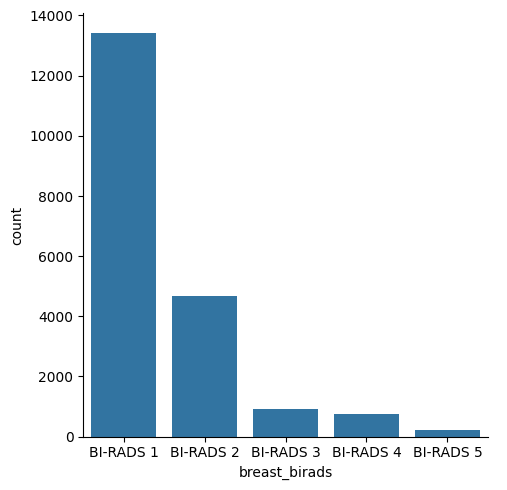

In [ ]:
sns.catplot(x='breast_birads', data=data, order=['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5'], kind='count')


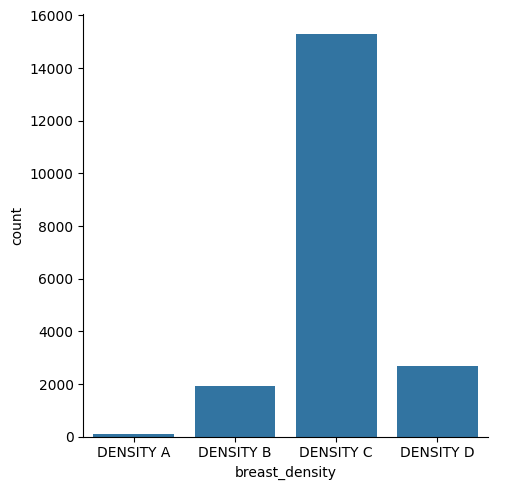

In [ ]:
sns.catplot(x='breast_density', order=['DENSITY A', 'DENSITY B', 'DENSITY C', 'DENSITY D'], data=data, kind='count')


In [ ]:
image_size = (512,512)


In [ ]:
image_folder = os.path.join(data_dir,'images')
data2 = data[data['study_id'].apply(lambda x : x in os.listdir(image_folder) )]

In [ ]:
preproc_dir = 'images_512x512'
out_dir = os.path.join(data_dir,preproc_dir)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
image_folder = os.path.join(data_dir,'images')



for study_id  in os.listdir(image_folder) :
  if not study_id == 'index.html':
    out_path = os.path.join(out_dir,study_id)
    if not os.path.exists(out_path):
          os.makedirs(out_path)

    for image_id in os.listdir(os.path.join(image_folder,study_id)):


      image_id = image_id.split('.')[0]
      img_path = os.path.join(data_dir, 'images', study_id, image_id + '.dicom')
      out_fn = os.path.join(out_path, image_id + '.png')

      if not os.path.exists(out_fn) and not image_id =='index':
          try:
            dicom = dcmread(img_path)
            image = dicom.pixel_array
            idx = data[data['image_id']==image_id].index[0]

            window = np.array(ast.literal_eval(data.loc[idx, 'Window Width']))
            level = np.array(ast.literal_eval(data.loc[idx, 'Window Center']))

            # Multiple window/level settings for IMS Giotto images
            if data.loc[idx, "Manufacturer's Model Name"] == 'GIOTTO IMAGE 3DL' or data.loc[idx, "Manufacturer's Model Name"] == 'GIOTTO CLASS':
                window = window[0]
                level = level[0]

            # MONOCHROME1 images need special handling for inverting pixel intensities
            if data.loc[idx, 'Photometric Interpretation'] == 'MONOCHROME1':
                image[image==1] += data.loc[idx, 'Pixel Padding Value']
                level = np.max(image) - level
                image = np.max(image) - image

            # Resize image
            image = resize(image, output_shape=image_size, preserve_range=True).astype(np.float32)

            # Normalize pixel intensities, and convert to 8-bit
            image -= (level - window/2)
            image /= window
            image[image<0] = 0
            image[image>1] = 1
            image *= 255

            # Flip image with laterality equals right
            if data.loc[idx, 'laterality'] == 'R':
                image = image[:, ::-1]

            # image.tofile(os.path.join(out_path, data.loc[idx, 'image_id'] + '.dat'))
            imsave(out_fn, image.astype(np.uint8))
          except:
            pass

In [ ]:
data2 = data2.reset_index()

In [ ]:
data2['split'] = 'training'

In [ ]:
data2['split'].iloc[2*len(data2)//3:] = 'test'

<ipython-input-11-194dff421624>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['split'].iloc[2*len(data2)//3:] = 'test'


In [ ]:
data2['split'].value_counts()

split
training    109
test         55
Name: count, dtype: int64